# 🧠 Feature Vectors & Embeddings - Practical Introduction

This notebook builds intuition for representing data (numbers, text) as vectors, measuring similarity (cosine, distance), and eventually using modern embeddings.

**1‑Hour Session Flow (today's focus):**

0. Setup & goals
1. From tabular data to vectors (geometry & distance)
2. Bag‑of‑Words (BoW) – sparse text vectors & limitations
3. Enter dense embeddings 
4. Vectors distance/similarity algorithms comparison

---
### ✅ Learning Goals (for first pass)
- See any data row as a numeric vector in a multidimensional space
- Visualize vectors in 2D (PCA) & observe clustering
- Understand different types of vectors (raw features | sparse | dense vectors), their strengths, limitations and applications
- Text represented as embeddings/vectors
- Measuring distance/similarity between vectors and what it means


## 0. Setup & Imports
We'll start with a lightweight set of dependencies already in the project (pandas, numpy, scikit-learn, seaborn, matplotlib). No heavyweight embedding models yet.

Run the next cell to import utilities.

In [1]:
# Core imports for vector operations & visualization
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (7,4)

print("✅ Imports ready")

✅ Imports ready


## 1. From Tabular Data to Vectors
Goal: Connect something already familiar (tabular ML features) with the idea of *vectors in space*.

We will:
1. Create a tiny synthetic dataset (like toy house listings)
2. Standardize numeric features to comparable scale
3. Treat each row as a vector and compute distances / cosine similarity
4. Visualize in 2D using PCA

> Mental model: each data point = coordinate in multi‑dimensional space. Closeness ≈ similarity (with caveats about scaling & metric choice).

In [2]:
# Create a tiny synthetic tabular dataset (house-like features)
raw = pd.DataFrame({
    'rooms': [3, 4, 2, 5, 4, 3],
    'size_m2': [70, 95, 55, 140, 100, 75],
    'age_years': [30, 5, 45, 2, 12, 28],
    'distance_to_center_km': [8.0, 4.0, 12.0, 3.0, 5.0, 7.5],
    'price_k': [210, 360, 150, 560, 390, 240]
})

raw.head(6)

,rooms,size_m2,age_years,distance_to_center_km,price_k
0,3,70,30,8.0,210
1,4,95,5,4.0,360
2,2,55,45,12.0,150
3,5,140,2,3.0,560
4,4,100,12,5.0,390
5,3,75,28,7.5,240


In [3]:

features = ['rooms','size_m2','age_years','distance_to_center_km','price_k']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(raw[features])

print("First vector (raw):", raw[features].iloc[0].values)
print("First vector (scaled):", np.round(X_scaled[0], 3))

First vector (raw): [  3.  70.  30.   8. 210.]
First vector (scaled): [-0.522 -0.702  0.633  0.471 -0.795]


In [4]:
# calculate mean and std for each feature and compare raw vs scaled
means_raw = np.mean(raw[features].values, axis=0)
stds_raw = np.std(raw[features].values, axis=0)
print("Means (raw):", np.round(means_raw, 3))
print("Stds (raw):", np.round(stds_raw, 3))
# add min and max for better understanding
mins_raw = np.min(raw[features].values, axis=0)
maxs_raw = np.max(raw[features].values, axis=0)
print("Mins (raw):", np.round(mins_raw, 3))
print("Maxs (raw):", np.round(maxs_raw, 3))
means = np.mean(X_scaled, axis=0)
stds = np.std(X_scaled, axis=0)
print("Means (scaled):", np.round(means, 3))
print("Stds (scaled):", np.round(stds, 3))
# add min and max for better understanding
mins = np.min(X_scaled, axis=0)
maxs = np.max(X_scaled, axis=0)
print("Mins (scaled):", np.round(mins, 3))
print("Maxs (scaled):", np.round(maxs, 3))

Means (raw): [  3.5    89.167  20.333   6.583 318.333]
Stds (raw): [  0.957  27.297  15.283   3.006 136.311]
Mins (raw): [  2.  55.   2.   3. 150.]
Maxs (raw): [  5. 140.  45.  12. 560.]
Means (scaled): [ 0. -0.  0.  0.  0.]
Stds (scaled): [1. 1. 1. 1. 1.]
Mins (scaled): [-1.567 -1.252 -1.2   -1.192 -1.235]
Maxs (scaled): [1.567 1.862 1.614 1.802 1.773]



2D PCA visualization of the tabular vectors (scaled):


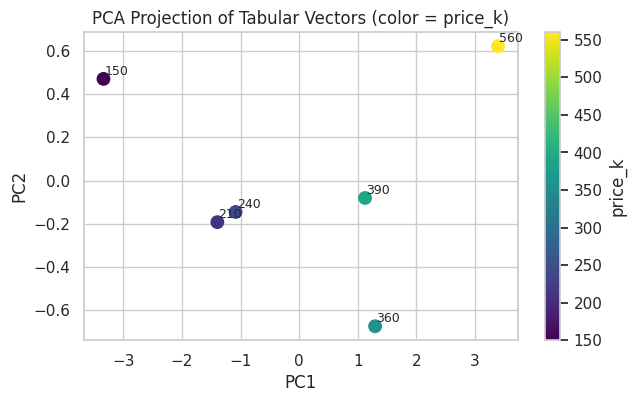

In [5]:
# 2D visualization with PCA (just for intuition)
print("\n2D PCA visualization of the tabular vectors (scaled):")
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

fig, ax = plt.subplots()
scatter = ax.scatter(coords[:,0], coords[:,1], c=raw['price_k'], cmap='viridis', s=80)
for i, price in enumerate(raw['price_k']):
    ax.annotate(str(price), (coords[i,0]+0.02, coords[i,1]+0.02), fontsize=9)

ax.set_title('PCA Projection of Tabular Vectors (color = price_k)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
cb = plt.colorbar(scatter)
cb.set_label('price_k')
plt.show()

In [6]:
# Explain the dimensionality of vectors in our tabular data

print("🔍 Understanding Vector Dimensionality\n")

print("1. What is dimensionality?")
print("   - Each feature becomes one dimension in vector space")
print("   - Our dataset has", len(features), "features, so each data point is a", len(features), "dimensional vector")
print("   - Features:", features)

print("\n2. Raw vs Scaled vectors:")
print("   Raw vector (house 0):", raw[features].iloc[0].values)
print("   Scaled vector (house 0):", np.round(X_scaled[0], 3))
print("   → Same dimensionality (", len(features), "D), but scaled values are comparable")

print("\n3. Vector space interpretation:")
print("   - Each house = one point in 5D space")
print("   - Distance between points = similarity between houses")
print("   - Cannot visualize 5D directly → use PCA to project to 2D")

print("\n4. Dimensionality comparison:")
print(f"   - Original data: {raw[features].shape[0]} houses × {raw[features].shape[1]} dimensions")
print(f"   - PCA projection: {coords.shape[0]} houses × {coords.shape[1]} dimensions (lossy compression)")
print(f"   - Information retained by 2D PCA: {sum(pca.explained_variance_ratio_):.1%}")

print("\n5. Why dimensionality matters:")
print("   - High dimensions = curse of dimensionality (distances become less meaningful)")
print("   - Low dimensions = easier to visualize but lose information")
print("   - Text data will have MUCH higher dimensionality (vocabulary size)")

🔍 Understanding Vector Dimensionality

1. What is dimensionality?
   - Each feature becomes one dimension in vector space
   - Our dataset has 5 features, so each data point is a 5 dimensional vector
   - Features: ['rooms', 'size_m2', 'age_years', 'distance_to_center_km', 'price_k']

2. Raw vs Scaled vectors:
   Raw vector (house 0): [  3.  70.  30.   8. 210.]
   Scaled vector (house 0): [-0.522 -0.702  0.633  0.471 -0.795]
   → Same dimensionality ( 5 D), but scaled values are comparable

3. Vector space interpretation:
   - Each house = one point in 5D space
   - Distance between points = similarity between houses
   - Cannot visualize 5D directly → use PCA to project to 2D

4. Dimensionality comparison:
   - Original data: 6 houses × 5 dimensions
   - PCA projection: 6 houses × 2 dimensions (lossy compression)
   - Information retained by 2D PCA: 99.7%

5. Why dimensionality matters:
   - High dimensions = curse of dimensionality (distances become less meaningful)
   - Low dimensio

### 🔍 Reflection
- Each row became a **vector** after scaling.
- PCA gave a lossy 2D view; proximity there roughly reflects multi-dimensional similarity.

> If something felt unclear, add a note now before we proceed to text.

## 2. Bag-of-Words (BoW): Text → Sparse Vectors
We now turn short texts into vectors using vocabulary counts.

Steps:
1. Build a mini corpus
2. Tokenize & build vocabulary
3. Create count matrix (documents × vocabulary)
4. Compare documents (cosine similarity)
5. Reduce & visualize
6. Note limitations (synonyms, sparsity, order ignorance)


In [7]:
# Mini corpus (short, varied topics)
corpus = [
    "Dogs love playing in sunny parks",
    "Puppies enjoy fun sunny walks",
    "Stock markets fell after economic report",
    "Investors fear market volatility and risk",
    "Cats prefer quiet shaded gardens",
    "Economic growth reports boosted investor optimism",
    "Canines really like playful outdoor activities",
    "Market turbulence increases investor caution",
    "Solar energy adoption is accelerating worldwide",
    "Kittens often enjoy quiet garden spaces",
]

# Basic tokenization (lowercase + split). For pedagogy (not production!)
import re

def tokenize(text):
    return re.findall(r"[a-zA-Z]+", text.lower())

tokenized = [tokenize(doc) for doc in corpus]

# Build vocabulary
from collections import Counter
vocab_counter = Counter(token for doc in tokenized for token in doc)
vocab = sorted(vocab_counter)  # alphabetical for reproducibility
idx = {w:i for i,w in enumerate(vocab)}

# Build count matrix
matrix = np.zeros((len(corpus), len(vocab)), dtype=int)
for doc_i, doc in enumerate(tokenized):
    for token in doc:
        matrix[doc_i, idx[token]] += 1

bow_df = pd.DataFrame(matrix, columns=vocab)
print("Vocabulary size:", len(vocab))
print("BoW shape:", bow_df.shape)

# display full dataframe width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
bow_df.head()

Vocabulary size: 51
BoW shape: (10, 51)


,accelerating,activities,adoption,after,and,boosted,canines,cats,caution,dogs,economic,energy,enjoy,fear,fell,fun,garden,gardens,growth,in,increases,investor,investors,is,kittens,like,love,market,markets,often,optimism,outdoor,parks,playful,playing,prefer,puppies,quiet,really,report,reports,risk,shaded,solar,spaces,stock,sunny,turbulence,volatility,walks,worldwide
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [8]:
# Show individual vectors
# make sure notebook output cell does not truncate or move long lines to next line
# not related to pandas display settings

print("First vector: ", bow_df.iloc[0].values[:35])
print("Second vector:", bow_df.iloc[1].values[:35])
print("Third vector: ", bow_df.iloc[2].values[:35])
print("Forth vector: ", bow_df.iloc[3].values[:35])
print("Fifth vector: ", bow_df.iloc[4].values[:35])

First vector:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1]
Second vector: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Third vector:  [0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Forth vector:  [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
Fifth vector:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


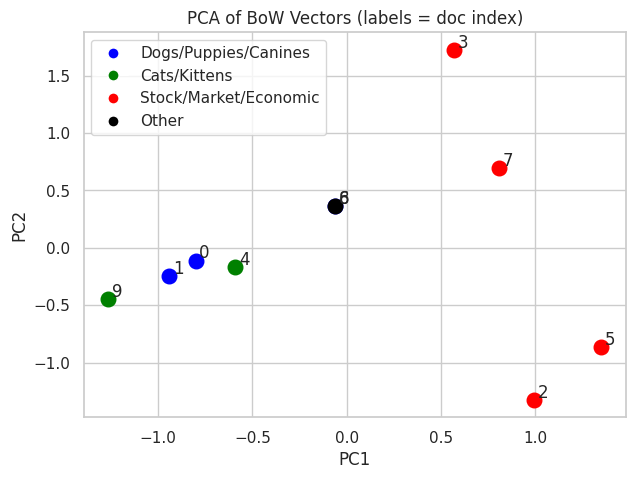

0: Dogs love playing in sunny parks
1: Puppies enjoy fun sunny walks
2: Stock markets fell after economic report
3: Investors fear market volatility and risk
4: Cats prefer quiet shaded gardens
5: Economic growth reports boosted investor optimism
6: Canines really like playful outdoor activities
7: Market turbulence increases investor caution
8: Solar energy adoption is accelerating worldwide
9: Kittens often enjoy quiet garden spaces


In [9]:
from matplotlib.lines import Line2D

# Visualize BoW vectors in 2D (PCA)
pca_bow = PCA(n_components=2, random_state=42)
coords_bow = pca_bow.fit_transform(bow_df.values)

plt.figure(figsize=(7,5))

# Define colors for different categories
colors_bow = []
for i, sentence in enumerate(corpus):
    sentence_lower = sentence.lower()
    if any(word in sentence_lower for word in ['dog', 'puppies', 'canine']):
        colors_bow.append('blue')    # dogs/puppies/canines
    elif any(word in sentence_lower for word in ['kitten', 'cat']):
        colors_bow.append('green')   # cats/kittens
    elif any(word in sentence_lower for word in ['stock', 'market', 'investor', 'economic']):
        colors_bow.append('red')     # stock market related
    else:
        colors_bow.append('black')   # everything else

for i, (x, y) in enumerate(coords_bow):
    plt.scatter(x, y, color=colors_bow[i], s=110)
    plt.annotate(str(i), (x+0.02, y+0.02))

plt.title('PCA of BoW Vectors (labels = doc index)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legend
legend_elements_bow = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Dogs/Puppies/Canines'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Cats/Kittens'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Stock/Market/Economic'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Other')]
plt.legend(handles=legend_elements_bow, loc='best')
plt.show()

for i, doc in enumerate(corpus):
    print(f"{i}: {doc}")

### 🔍 BoW Reflection & Limitations
**What worked:**
- Simple to implement & fast for small corpora
- Captures word presence & rough topical similarity

**Limitations:**
- Treats words as independent (order ignored)
- Vocabulary growth → very high dimensional sparse vectors
- Synonyms not linked ("dogs" vs "puppies" partly overlap only by shared words like *love* if present)
- Rare words overweighted; common words might dominate unless reweighted (→ TF‑IDF)

> Next: move to **dense embeddings** that place semantically similar texts *closer* even without shared surface tokens.

## 3. Enter Embeddings: Dense Semantic Vectors
Sparse BoW vectors rely on exact token overlap. **Embeddings** map text to a dense, low(er)-dimensional space where *semantic* closeness (meaning) is reflected by vector proximity.

### Key Differences vs BoW
| Aspect | BoW / Counts | Dense Embeddings |
|--------|--------------|------------------|
| Dimensionality | Vocabulary size (hundreds–millions) | Fixed (e.g. 384 / 768) |
| Sparsity | Mostly zeros | Fully dense |
| Synonyms | Far apart (no shared tokens) | Close (context learned) |
| Word order | Ignored (basic BoW) | Captured (contextual models) |
| Out-of-vocabulary Handling | Fails/ignores | Subwords or character pieces |

We'll use a lightweight **Sentence Transformer** (MiniLM) to produce sentence-level embeddings for the same corpus plus some semantically related and unrelated sentences.

> If the library isn't installed, the next code cell will attempt to install it automatically.

In [10]:
# Install sentence-transformers if missing (lightweight model)
import importlib, sys, subprocess
from sentence_transformers import SentenceTransformer


model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
print(f"Loaded model: {model_name}")

semantic_corpus = corpus 

embeddings = model.encode(semantic_corpus, normalize_embeddings=True)
print("Embeddings shape:", embeddings.shape)
print("First vector (truncated):", np.round(embeddings[0][:10], 3), '...')

Loaded model: sentence-transformers/all-MiniLM-L6-v2
Embeddings shape: (10, 384)
First vector (truncated): [ 0.023 -0.052  0.068  0.054 -0.007  0.032  0.099 -0.067  0.041  0.043] ...


### Inspecting Semantic Similarity
Above we used a pre-trained MiniLM model to embed (create vector representation) each sentence.  
Next, we will leverage PCA to visualize (with loss) how close some of these sentences are thanks to these new representations we gave them.  

Key observations you should see:
- Synonyms / paraphrases ("Dogs love playing in the park" vs "Canines really like going to parks") are close to each other.
- The stock market sentences cluster separately from the animal sentences.
- This worked even though some words are not identical (dog vs canines, playing vs going to).

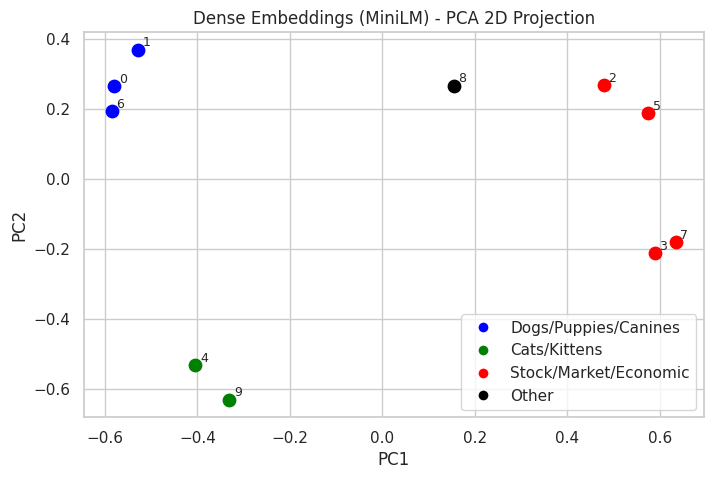

Index to sentence mapping:
0: Dogs love playing in sunny parks
1: Puppies enjoy fun sunny walks
2: Stock markets fell after economic report
3: Investors fear market volatility and risk
4: Cats prefer quiet shaded gardens
5: Economic growth reports boosted investor optimism
6: Canines really like playful outdoor activities
7: Market turbulence increases investor caution
8: Solar energy adoption is accelerating worldwide
9: Kittens often enjoy quiet garden spaces


In [11]:
# 3.3 Visualize dense embeddings (PCA)

pca2 = PCA(n_components=2, random_state=42)
emb_2d = pca2.fit_transform(embeddings)

plt.figure(figsize=(8,5))

# Define colors for different categories
colors = []
for i, sentence in enumerate(semantic_corpus):
    sentence_lower = sentence.lower()
    if any(word in sentence_lower for word in ['dog', 'puppies', 'canine', 'kitten', 'cat']):
        if any(word in sentence_lower for word in ['kitten', 'cat']):
            colors.append('green')  # cats/kittens
        else:
            colors.append('blue')    # dogs/puppies/canines
    elif any(word in sentence_lower for word in ['stock', 'market', 'investor', 'economic']):
        colors.append('red')         # stock market related
    else:
        colors.append('black')       # everything else

for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y, color=colors[i], s=80)
    plt.text(x+0.01, y+0.01, str(i), fontsize=9)

plt.title('Dense Embeddings (MiniLM) - PCA 2D Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Dogs/Puppies/Canines'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Cats/Kittens'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Stock/Market/Economic'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Other')]
plt.legend(handles=legend_elements, loc='best')
plt.show()

print("Index to sentence mapping:")
for i, s in enumerate(semantic_corpus):
    print(f"{i}: {s}")


### Reflection: Dense vs BoW Spaces
Compare this plot with the earlier BoW PCA projection:

- BoW relied on raw token overlap; semantically close sentences with different surface forms (dog/canine, playing/going) could appear farther apart.
- Dense embeddings compress multi-word semantics into directions so paraphrases cluster more tightly.
- High-dimensional geometry means some separation may not fully appear in a 2D PCA slice; UMAP (if installed) can sometimes reveal clearer groupings.
- Small corpora can yield unstable projections; with more sentences, thematic clusters (pets, finance, weather, travel) become more distinct.

**Takeaway: Dense models capture meaning beyond literal word overlap, enabling better retrieval and clustering.**


## 4. Vectors distance/similarity algorithms comparison

Now that we've explored both sparse BoW vectors and dense embeddings, let's compare different similarity/distance metrics and understand when to use each one.

#### Popular algorithms comparison: 
| Metric | Formula | Best For | Limitation |
|--------|---------|----------|------------|
| **Cosine Similarity** | cos(θ) = A·B / (‖A‖ ‖B‖) | Normalized embeddings, text similarity | Ignores magnitude (sentence length) |
| **Euclidean Distance** | √Σ(aᵢ - bᵢ)² | Raw feature vectors, spatial data | Sensitive to scale, curse of dimensionality |
| **Manhattan Distance** | Σ\|aᵢ - bᵢ\| | Sparse vectors, discrete features | Less smooth, sensitive to outliers |

#### Key Insights:
- **Cosine similarity** measures the angle between vectors, making it perfect for high-dimensional sparse vectors (BoW) and dense embeddings where direction matters more than magnitude
- **Euclidean distance** works well for low-dimensional continuous features but becomes less meaningful in high dimensions
- **Manhattan distance** is robust to outliers and works well with categorical or sparse data

Let's demonstrate these differences with our tabular data and embeddings:


🔍 Distance/Similarity Metrics Comparison
Vector A (Blue):  [1 1]
Vector B (Green): [10 10]
Vector C (Red):   [1 2]


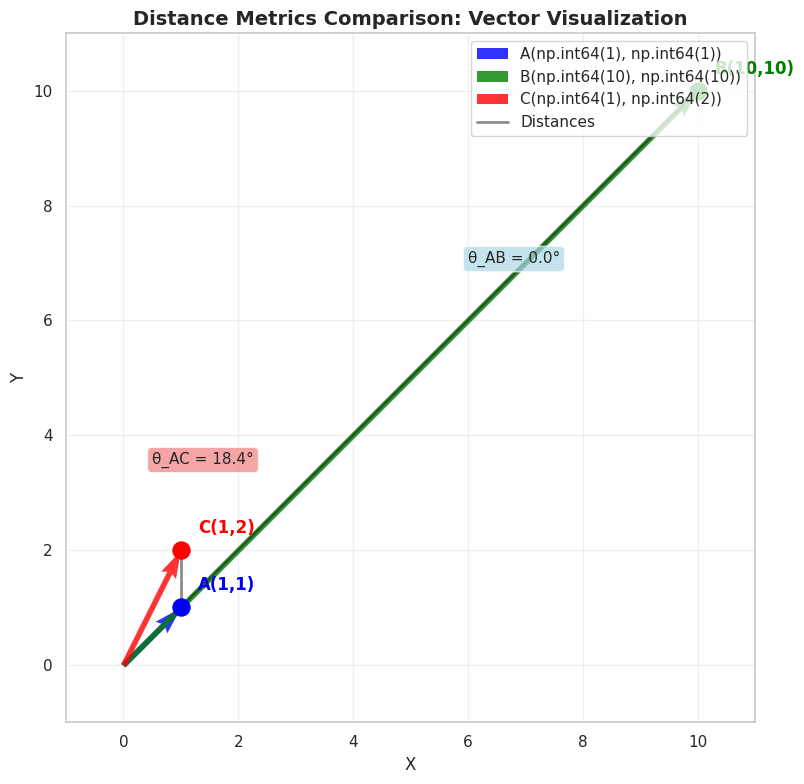


📊 Detailed Metrics Comparison
Pair     Cosine Similarity  Euclidean Dist  Manhattan Dist 
------------------------------------------------------------
A–B      1.000              12.7            18             
A–C      0.949              1.0             1              
B–C      0.949              12.0            17             

🔍 Key Interpretations:
📐 A vs B:
   • Cosine similarity ≈ 1.000 (they point in the SAME direction)
   • Euclidean distance ≈ 12.7 (they're FAR apart in scale)
   • Manhattan distance = 18 (very far apart)

📐 A vs C:
   • Cosine similarity ≈ 0.949 (similar, but not identical direction)
   • Euclidean distance ≈ 1.0 (actually quite close in space)
   • Manhattan distance = 1 (close)

💡 Why This Matters:
   → Cosine similarity focuses on DIRECTION/ORIENTATION
   → Euclidean distance focuses on SPATIAL CLOSENESS
   → Manhattan distance focuses on GRID-BASED CLOSENESS
   → For embeddings, we usually care about semantic DIRECTION (cosine)


In [12]:
# 🎯 Distance Metrics Comparison: Visual Explanation
# Let's compare three key distance metrics using specific example vectors

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# Define the example vectors
vec_A = np.array([1, 1])    # Blue point
vec_B = np.array([10, 10])  # Green point  
vec_C = np.array([1, 2])    # Red point

print("🔍 Distance/Similarity Metrics Comparison")
print("=" * 50)
print(f"Vector A (Blue):  {vec_A}")
print(f"Vector B (Green): {vec_B}")
print(f"Vector C (Red):   {vec_C}")

# Calculate all metrics
def calculate_all_metrics(v1, v2, label1, label2):
    """Calculate cosine similarity, euclidean distance, and manhattan distance"""
    
    # Cosine similarity (using sklearn for consistency)
    cos_sim = cosine_similarity([v1], [v2])[0, 0]
    
    # Euclidean distance
    eucl_dist = np.sqrt(np.sum((v1 - v2) ** 2))
    
    # Manhattan distance
    manh_dist = np.sum(np.abs(v1 - v2))
    
    return cos_sim, eucl_dist, manh_dist

# Calculate metrics for all pairs
cos_AB, eucl_AB, manh_AB = calculate_all_metrics(vec_A, vec_B, "A", "B")
cos_AC, eucl_AC, manh_AC = calculate_all_metrics(vec_A, vec_C, "A", "C")
cos_BC, eucl_BC, manh_BC = calculate_all_metrics(vec_B, vec_C, "B", "C")

# Create vector visualization only
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Vector visualization with all three vectors
origin = np.array([0, 0])
ax.quiver(*origin, *vec_A, angles='xy', scale_units='xy', scale=1, 
          color='blue', width=0.008, label=f'A{tuple(vec_A)}', alpha=0.8)
ax.quiver(*origin, *vec_B, angles='xy', scale_units='xy', scale=1, 
          color='green', width=0.008, label=f'B{tuple(vec_B)}', alpha=0.8)
ax.quiver(*origin, *vec_C, angles='xy', scale_units='xy', scale=1, 
          color='red', width=0.008, label=f'C{tuple(vec_C)}', alpha=0.8)

# Add points at vector endpoints
ax.scatter(*vec_A, color='blue', s=150, zorder=5)
ax.scatter(*vec_B, color='green', s=150, zorder=5)
ax.scatter(*vec_C, color='red', s=150, zorder=5)

# Add vector labels
ax.annotate('A(1,1)', xy=vec_A, xytext=(vec_A[0]+0.3, vec_A[1]+0.3), 
            fontsize=12, color='blue', fontweight='bold')
ax.annotate('B(10,10)', xy=vec_B, xytext=(vec_B[0]+0.3, vec_B[1]+0.3), 
            fontsize=12, color='green', fontweight='bold')
ax.annotate('C(1,2)', xy=vec_C, xytext=(vec_C[0]+0.3, vec_C[1]+0.3), 
            fontsize=12, color='red', fontweight='bold')

# Draw distance lines with different styles
ax.plot([vec_A[0], vec_B[0]], [vec_A[1], vec_B[1]], 'k-', alpha=0.5, linewidth=2, label='Distances')
ax.plot([vec_A[0], vec_C[0]], [vec_A[1], vec_C[1]], 'k-', alpha=0.5, linewidth=2)

# Add angle indicators
theta_A = np.arctan2(vec_A[1], vec_A[0])
theta_B = np.arctan2(vec_B[1], vec_B[0])
theta_C = np.arctan2(vec_C[1], vec_C[0])

ax.annotate(f'θ_AB = {np.degrees(abs(theta_A - theta_B)):.1f}°', 
            xy=(6, 7), fontsize=11, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
ax.annotate(f'θ_AC = {np.degrees(abs(theta_A - theta_C)):.1f}°', 
            xy=(0.5, 3.5), fontsize=11, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.set_title('Distance Metrics Comparison: Vector Visualization', fontsize=14, fontweight='bold')
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed comparison table
print("\n📊 Detailed Metrics Comparison")
print("=" * 60)
print(f"{'Pair':<8} {'Cosine Similarity':<18} {'Euclidean Dist':<15} {'Manhattan Dist':<15}")
print("-" * 60)
print(f"{'A–B':<8} {cos_AB:<18.3f} {eucl_AB:<15.1f} {manh_AB:<15.0f}")
print(f"{'A–C':<8} {cos_AC:<18.3f} {eucl_AC:<15.1f} {manh_AC:<15.0f}")
print(f"{'B–C':<8} {cos_BC:<18.3f} {eucl_BC:<15.1f} {manh_BC:<15.0f}")

print("\n🔍 Key Interpretations:")
print("=" * 40)
print("📐 A vs B:")
print(f"   • Cosine similarity ≈ {cos_AB:.3f} (they point in the SAME direction)")
print(f"   • Euclidean distance ≈ {eucl_AB:.1f} (they're FAR apart in scale)")
print(f"   • Manhattan distance = {manh_AB:.0f} (very far apart)")

print("\n📐 A vs C:")
print(f"   • Cosine similarity ≈ {cos_AC:.3f} (similar, but not identical direction)")
print(f"   • Euclidean distance ≈ {eucl_AC:.1f} (actually quite close in space)")
print(f"   • Manhattan distance = {manh_AC:.0f} (close)")

print("\n💡 Why This Matters:")
print("   → Cosine similarity focuses on DIRECTION/ORIENTATION")
print("   → Euclidean distance focuses on SPATIAL CLOSENESS") 
print("   → Manhattan distance focuses on GRID-BASED CLOSENESS")
print("   → For embeddings, we usually care about semantic DIRECTION (cosine)")

### Apply Cosine Similarity for Text Embeddings

In [13]:
# import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix for embeddings
emb_cos = cosine_similarity(embeddings)

import numpy as np

# Helper: show top-k similar sentences for a query index
def show_top_k(idx, k=5):
    scores = emb_cos[idx]
    ranked = np.argsort(-scores)
    print(f"\nQuery [{idx}]: {semantic_corpus[idx]}")
    print("Top matches:")
    for r in ranked[1:k+1]:  # skip self
        print(f"  • ({r}) score={scores[r]:.3f} :: {semantic_corpus[r]}")

# Demonstrate for a few queries
show_top_k(0)   # dogs
show_top_k(4)   # stock markets
show_top_k(3)  # last added (kittens / gardens)


Query [0]: Dogs love playing in sunny parks
Top matches:
  • (6) score=0.677 :: Canines really like playful outdoor activities
  • (1) score=0.673 :: Puppies enjoy fun sunny walks
  • (4) score=0.458 :: Cats prefer quiet shaded gardens
  • (9) score=0.287 :: Kittens often enjoy quiet garden spaces
  • (8) score=0.151 :: Solar energy adoption is accelerating worldwide

Query [4]: Cats prefer quiet shaded gardens
Top matches:
  • (9) score=0.718 :: Kittens often enjoy quiet garden spaces
  • (0) score=0.458 :: Dogs love playing in sunny parks
  • (6) score=0.448 :: Canines really like playful outdoor activities
  • (1) score=0.318 :: Puppies enjoy fun sunny walks
  • (8) score=0.124 :: Solar energy adoption is accelerating worldwide

Query [3]: Investors fear market volatility and risk
Top matches:
  • (7) score=0.676 :: Market turbulence increases investor caution
  • (5) score=0.399 :: Economic growth reports boosted investor optimism
  • (2) score=0.269 :: Stock markets fell after ec